<a href="https://colab.research.google.com/github/hiiambobby/Spam-Detector-LSTM-PyTorch/blob/main/Spam_Detector_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import re
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [ ]:

url = "https://raw.githubusercontent.com/justmarkham/pycon-2016-tutorial/master/data/sms.tsv"
data = pd.read_csv(url, sep='\t', header=None, names=['label', 'message'])

print(data.head())


  label                                            message
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...


In [ ]:
#Preprocessing
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)
    return text

data['message'] = data['message'].apply(clean_text)

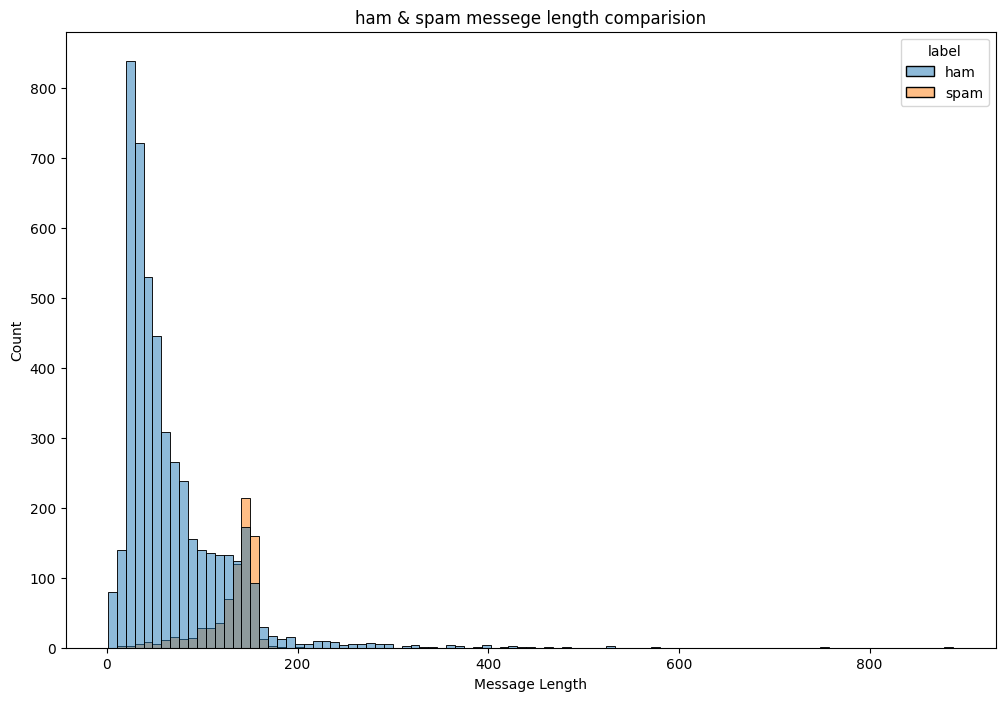

In [ ]:
data["Message Length"]=data["message"].apply(len)

fig=plt.figure(figsize=(12,8))
sns.histplot(
    x=data["Message Length"],
    hue=data["label"]
)
plt.title("ham & spam messege length comparision")
plt.show()

In [ ]:
data.describe(include="all")


,label,message,Message Length
count,5572,5572,5572.000000
unique,2,5141,NaN
top,ham,sorry ill call later,NaN
freq,4825,30,NaN
mean,NaN,NaN,76.198851
std,NaN,NaN,57.012105
min,NaN,NaN,1.000000
25%,NaN,NaN,33.000000
50%,NaN,NaN,58.000000
75%,NaN,NaN,116.000000


In [ ]:
# Data Balancing: Instead of undersampling, we will use class weights during training.
# We will keep the original 'data' DataFrame for this purpose.
# The 'df' DataFrame created by undersampling is no longer needed for training with class weights.
# We will proceed with the original 'data' DataFrame for encoding and training.

In [ ]:
print(type(data['label'].iloc[0]), data['label'].iloc[0])


<class 'str'> ham


In [ ]:
data.shape


(5572, 3)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Use the original 'data' DataFrame for label encoding
data['label'] = LabelEncoder().fit_transform(data['label'])  # ham = 0, spam = 1

# Calculate class weights
class_counts = data['label'].value_counts()
total_samples = len(data)
# Weights are inversely proportional to class frequencies
class_weights = total_samples / (2 * class_counts)
# Convert to a tensor and move to the appropriate device
class_weights = torch.tensor([class_weights[0], class_weights[1]], dtype=torch.float32).to(device)

print("Class weights calculated:")
print(f"Weight for class 0 (ham): {class_weights[0].item():.4f}")
print(f"Weight for class 1 (spam): {class_weights[1].item():.4f}")

Class weights calculated:
Weight for class 0 (ham): 0.5774
Weight for class 1 (spam): 3.7296


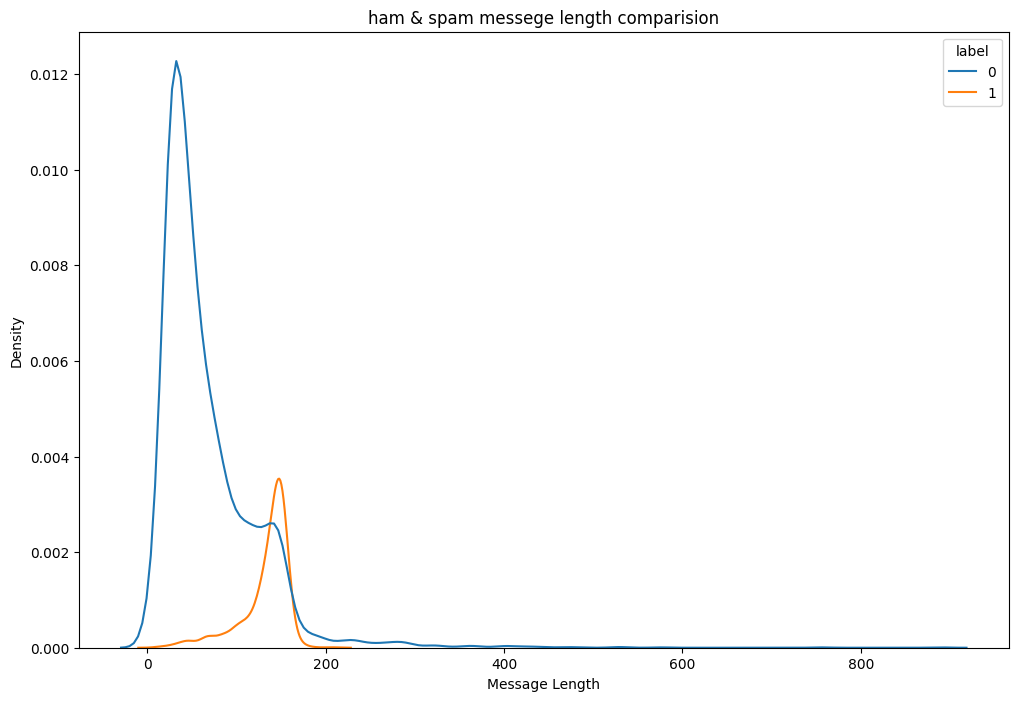

In [ ]:
fig=plt.figure(figsize=(12,8))
sns.kdeplot(
    x=data["Message Length"],
    hue=data["label"]
)
plt.title("ham & spam messege length comparision")
plt.show()


In [ ]:
# vocab building - use the original 'data' DataFrame
all_text = ' '.join(data['message']).split()
word_counts = Counter(all_text)
vocab = {word: i + 2 for i, (word, _) in enumerate(word_counts.most_common())}
vocab['<PAD>'] = 0 #when we want sentences to be the same lenghts we use this
vocab['<UNK>'] = 1 #unknown words


#words to emdeddings - use the original 'data' DataFrame
def encode_message(msg):
  return [vocab.get(word, vocab['<UNK>'])for word in msg.split()]

data['encoded'] = data['message'].apply(encode_message)

#adding the padding - use the original 'data' DataFrame
max_len = max(data['encoded'].apply(len))  #find the longest message
def pad_sequence_fn(seq):
  return torch.tensor(seq + [0] * (max_len - len(seq)))
data['padded'] = data['encoded'].apply(pad_sequence_fn)

In [ ]:
# make the dataset and dataloader - use the original 'data' DataFrame
class SMSDataset(Dataset):

  def __init__(self,messages,labels):
    self.messages = messages
    self.labels = labels

  def __len__(self):
    return len(self.messages)

  def __getitem__(self,idx):
    return self.messages[idx], self.labels[idx]

# Split data into training (60%), validation (20%), and test (20%) sets
X_train_val, X_test, y_train_val, y_test = train_test_split(
    data['padded'].tolist(),
    data['label'].tolist(),
    test_size=0.2,
    stratify=data['label'],
    random_state=42 # for reproducibility
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val,
    y_train_val,
    test_size=0.25, # 0.25 of 80% is 20% of the original data
    stratify=y_train_val,
    random_state=42 # for reproducibility
)


train_dataset = SMSDataset(X_train, y_train)
val_dataset = SMSDataset(X_val, y_val)
test_dataset = SMSDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Training samples: 3342
Validation samples: 1115
Test samples: 1115


In [ ]:
class SpamClassifier(nn.Module):
  def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
    super(SpamClassifier, self).__init__()
    self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
    self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
    self.fc = nn.Linear(hidden_dim, output_dim)
    self.sigmoid = nn.Sigmoid()



  def forward(self, x):
      embedded = self.embedding(x)                # [batch_size, seq_len, emb_dim]
      _, (hidden, _) = self.lstm(embedded)        # hidden: [1, batch_size, hidden_dim]
      out = self.fc(hidden[-1])                   # [batch_size, output_dim]
      return self.sigmoid(out)


In [ ]:
#training the model

model = SpamClassifier(
    vocab_size=len(vocab),
    embedding_dim=64,
    hidden_dim=128,
    output_dim=1
)
model.to(device)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(),lr = 0.001)





In [ ]:
try:
   checkpoint = torch.load('spam_model_checkpoint.pth')
   model.load_state_dict(checkpoint['model_state_dict'])
   optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
   start_epoch = checkpoint['epoch']
   epoch_losses = checkpoint['losses']
   val_losses = checkpoint.get('val_losses', []) # Load validation losses if they exist
   print(f"Resuming training from epoch {start_epoch}")
except FileNotFoundError:
    start_epoch = 0
    epoch_losses = []
    val_losses = []
    print("Starting fresh training with class weights")

num_epochs = 10
best_val_loss = float('inf') # Initialize best validation loss for early stopping
epochs_no_improve = 0 # Counter for epochs with no improvement

for epoch in range(start_epoch, num_epochs):
    model.train()
    total_train_loss = 0
    for batch_x, batch_y in train_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.float().unsqueeze(1).to(device)

        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    epoch_losses.append(avg_train_loss)

    # Evaluate on validation set
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for batch_x_val, batch_y_val in val_loader:
            batch_x_val = batch_x_val.to(device)
            batch_y_val = batch_y_val.float().unsqueeze(1).to(device)
            outputs_val = model(batch_x_val)
            val_loss = criterion(outputs_val, batch_y_val)
            total_val_loss += val_loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

    # Check for early stopping (optional but recommended)
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        # You might want to save the best model checkpoint here
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'losses': epoch_losses,
            'val_losses': val_losses, # Save validation losses
            'best_val_loss': best_val_loss # Save best validation loss
        }, 'spam_model_best_checkpoint.pth') # Save best model separately
    else:
        epochs_no_improve += 1
        # Define a patience value for early stopping
        patience = 5
        if epochs_no_improve == patience:
            print(f"Early stopping after {patience} epochs with no improvement on validation loss.")
            break # Stop training

    # Save checkpoint after each epoch (can be the current state or the best state)
    # For simplicity, saving the current state here. You can choose to only save the best.
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'losses': epoch_losses,
        'val_losses': val_losses # Save validation losses
    }, 'spam_model_checkpoint.pth')

Resuming training from epoch 10


In [ ]:
# Evaluate on the test set (after training is complete)
model.eval()
correct = 0
total = 0
total_test_loss = 0 # Calculate test loss as well

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x = batch_x.to(device)
        # Convert batch_y to float to match the expected type for the criterion
        batch_y = batch_y.float().unsqueeze(1).to(device)

        outputs = model(batch_x)
        test_loss = criterion(outputs, batch_y)
        total_test_loss += test_loss.item()

        predicted = (outputs > 0.5).float()  # Convert probabilities to 0/1
        correct += (predicted == batch_y).sum().item()
        total += batch_y.size(0)

test_accuracy = 100 * correct / total
avg_test_loss = total_test_loss / len(test_loader)

print(f"Test Accuracy: {test_accuracy:.2f}%")
print(f"Test Loss: {avg_test_loss:.4f}")

# You can also evaluate on the validation set here if needed, but it's typically done during training
# print("\nEvaluating on Validation Set:")
# correct_val = 0
# total_val = 0
# with torch.no_grad():
#     for batch_x_val, batch_y_val in val_loader:
#         batch_x_val = batch_x_val.to(device)
#         batch_y_val = batch_y_val.unsqueeze(1).to(device)
#         outputs_val = model(batch_x_val)
#         predicted_val = (outputs_val > 0.5).float()
#         correct_val += (predicted_val == batch_y_val).sum().item()
#         total_val += batch_y_val.size(0)
# print(f"Validation Accuracy: {100 * correct_val / total_val:.2f}%")

Test Accuracy: 86.64%
Test Loss: 0.3935


In [ ]:
def predict_message(msg, model, vocab, max_len, threshold):
    model.eval()
    msg = msg.lower()
    msg = re.sub(r"[^a-zA-Z0-9\s]", "", msg)
    encoded = [vocab.get(word, vocab['<UNK>']) for word in msg.split()]
    padded = encoded + [0] * (max_len - len(encoded))
    input_tensor = torch.tensor(padded).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        prediction = (output > threshold).float().item()
        return "SPAM" if prediction == 1.0 else "HAM"

In [ ]:
predict_message("congrats 2 mobile 3g videophones r yours call 09061744553 now vide", model, vocab, max_len, threshold=0.2)
# → "SPAM"

'HAM'

In [ ]:
torch.save(model.state_dict(), "spam_model.pth")

#to load later:
# model = SpamClassifier(len(vocab), 64, 128, 1)
# model.load_state_dict(torch.load("spam_model.pth"))
# model.to(device)
# model.eval()
